# Create a background profile for your analysis
The background field is the first-guess field. It will be subtracted from your observations in order to work with anomalies in the analysis. The background field is then added to recover the original values.

In [1]:
using DIVAnd
using Test
using DelimitedFiles
using DataStructures
using Missings
using NCDatasets
using Statistics
using PyPlot

We consider the salinity data in the Procençal domain

In [2]:
varname = "Salinity"

"Salinity"

In [ ]:
We extract the bathymetry

In [3]:
obsname = "../data/WOD-Salinity-Provencal.nc"

if !isfile(obsname)
    @info("download observations $obsname")
    download("https://dox.uliege.be/index.php/s/PztJfSEnc8Cr3XN/download",obsname)
end

bathname = "../data/gebco_30sec_4.nc"
if !isfile(bathname)
    download("https://dox.uliege.be/index.php/s/U0pqyXhcQrXjEUX/download",bathname)
else
    @info("Bathymetry file already downloaded")
end
lonr = 3.:0.1:11.8
latr = 42.:0.1:44.5
bathisglobal = true
# Extract the bathymetry for plotting
bx,by,b = extract_bath(bathname,bathisglobal,lonr,latr);

┌ Info: Bathymetry file already downloaded
└ @ Main In[3]:12


We load the data

In [4]:
obsvalue, obslon, obslat, obsdepth, obstime, obsids = DIVAnd.loadobs(
    Float64,
    obsname,
    varname,
);

Exclude some outliers

In [5]:
badid = ["wod_015600782O","wod_015602753O","wod_015604717O","wod_015606732O","wod_015607117O","wod_015607524O","wod_015607893O","wod_015924970O","wod_015926914O","wod_015928739O","wod_016650545O", "wod_008518725O","wod_007643915O","wod_015875365O","wod_006614816O","wod_006614929O","wod_006614937O","wod_007644875O","wod_009996947O","wod_010742471O","wod_010742472O","wod_006614931O","wod_006614934O","wod_006625408O","wod_006752127O","wod_006752129O"]
good = (37.6 .< obsvalue .< 38.75) .& map(id -> !(id in badid),obsids)

obsvalue = obsvalue[good]
obslon = obslon[good]
obslat = obslat[good]
obsdepth = obsdepth[good]
obstime = obstime[good]
obsids = obsids[good];

Verify the data range

In [6]:
DIVAnd.checkobs((obslon, obslat, obsdepth, obstime),obsvalue,obsids)

┌ Info: Checking ranges for dimensions and observations
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/obsstat.jl:75


              minimum and maximum of obs. dimension 1: (3.0418334007263184, 11.8100004196167)
              minimum and maximum of obs. dimension 2: (42.0, 44.0)
              minimum and maximum of obs. dimension 3: (-0.0, 2762.0)
              minimum and maximum of obs. dimension 4: (1892-09-25T00:00:00, 2017-10-02T06:14:02.761)
                          minimum and maximum of data: (37.600101470947266, 38.74980163574219)


These are the considered depth levels 

In [7]:
depthr = [0.,5, 10, 15, 20, 25, 30, 40, 50, 66, 75, 85, 100, 112, 125, 135, 150, 175, 200, 225, 250, 275, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1600, 1750, 1850, 2000];

We make a seasonal profile for all data within 1950 and 2017

In [8]:
yearlist = [1950:2017]

# winter: January-March    1,2,3
# spring: April-June       4,5,6
# summer: July-September   7,8,9
# autumn: October-December 10,11,12

monthlists = [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]];

TS = DIVAnd.TimeSelectorYearListMonthList(yearlist, monthlists)

epsilon2 = ones(size(obsvalue));

In [9]:
?DIVAnd.average_background_profile

```
average_background_profile(
background_filename, (lonr,latr,depthr,TS), (obslon, obslat, obsdepth, obstime), obsvalue,
epsilon2,
varname;
transform = DIVAnd.Anam.notransform(),
searchz = background_profile_searchz(depthr),
```

Compute the average background profile by averaging the observations within a distance given by `searchz` and for each time instance defined in the time selector `TS`.


In [10]:
background_filename = "average_background_profile_$(varname).nc"

if isfile(background_filename)
    rm(background_filename)
end

DIVAnd.average_background_profile(
    background_filename, (lonr,latr,depthr,TS), (obslon, obslat, obsdepth, obstime), obsvalue,
    epsilon2,
    varname)

┌ Info: Time step 1 / 4
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/average_background_profile.jl:89
┌ Info: Time step 2 / 4
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/average_background_profile.jl:89
┌ Info: Time step 3 / 4
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/average_background_profile.jl:89
┌ Info: Time step 4 / 4
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/average_background_profile.jl:89


In [11]:
ds = Dataset(background_filename)

Dataset: average_background_profile_Salinity.nc
Group: /

Dimensions
   lon = 89
   lat = 26
   depth = 51
   time = 4

Variables
  Salinity   (89 × 26 × 51 × 4)
    Datatype:    Float32
    Dimensions:  lon × lat × depth × time



In [12]:
S = ds["Salinity"][1,1,:,:]
close(ds)

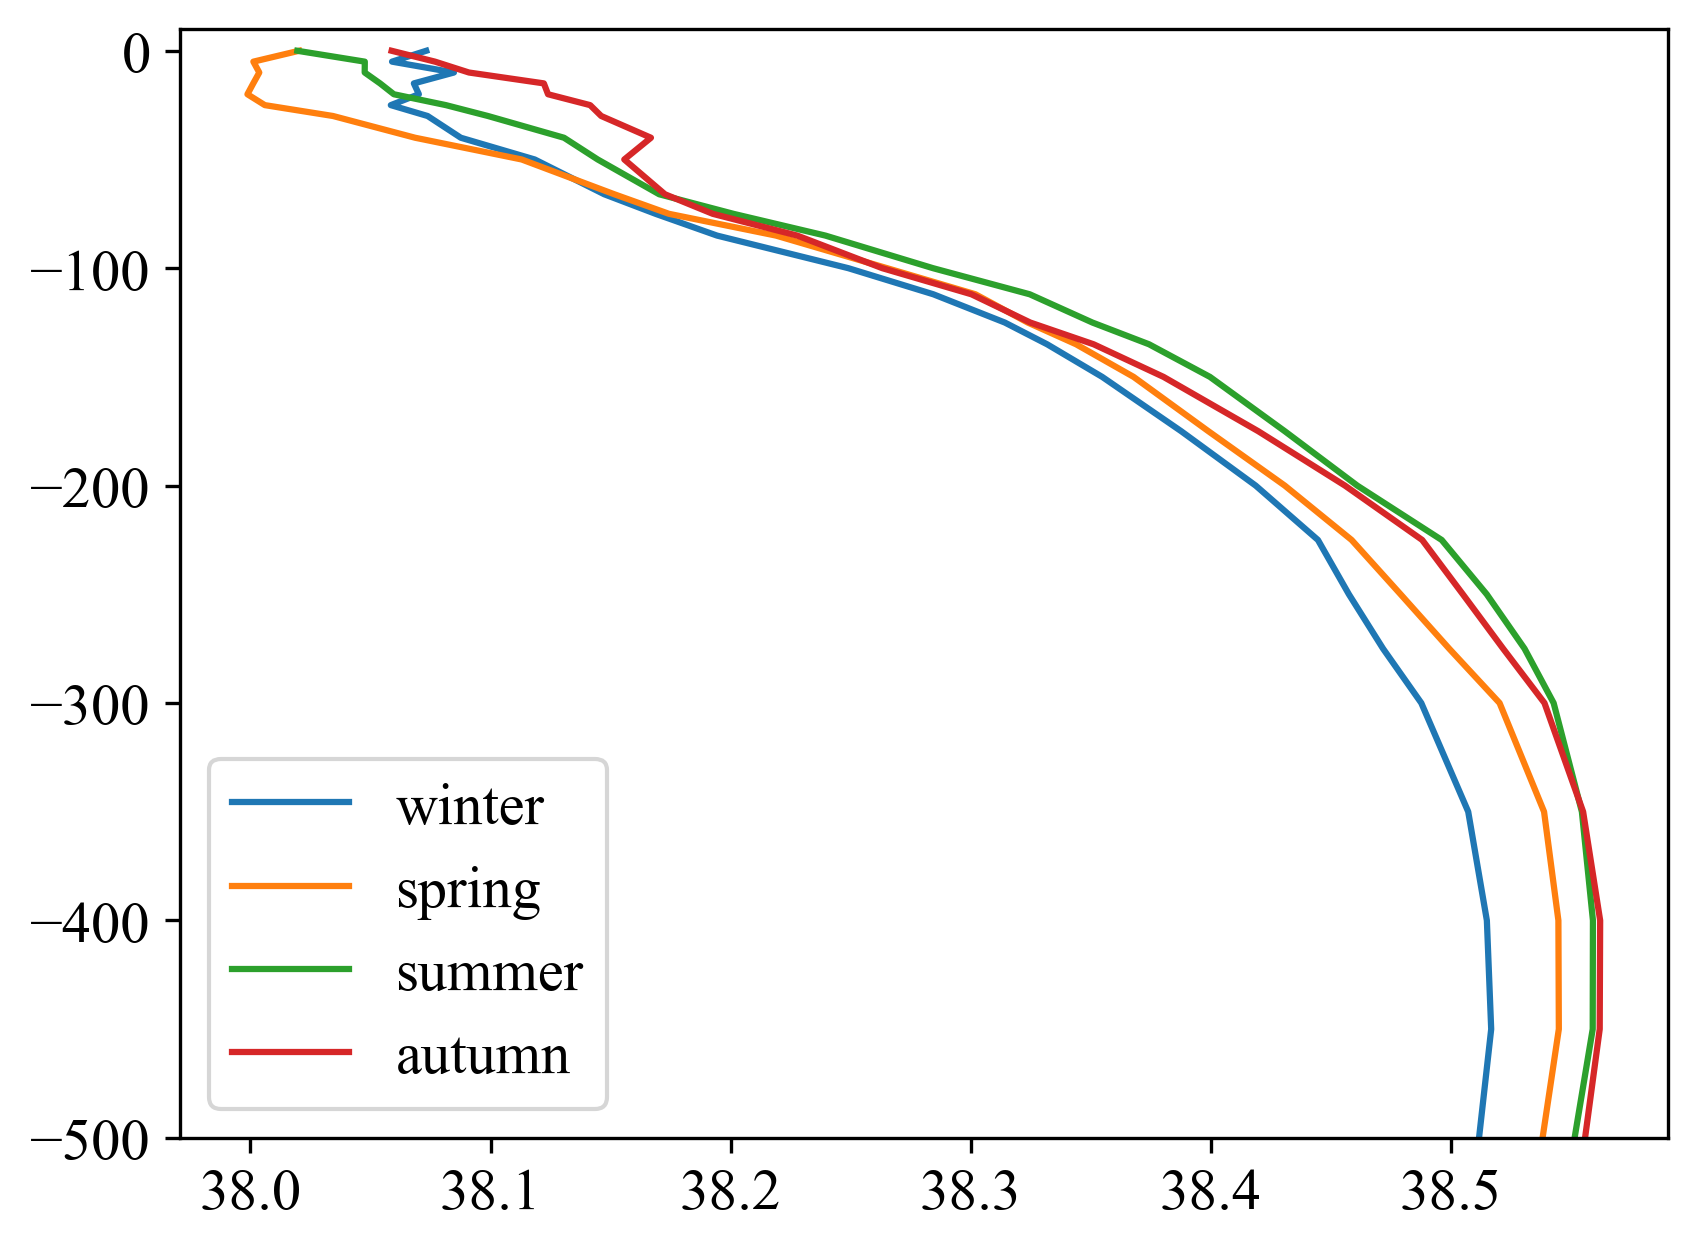

(-500, 10)

In [13]:
seasons = ["winter","spring","summer","autumn"]
for n = 1:length(seasons)
  plot(S[:,n],-depthr,label=seasons[n])
end
legend();
ylim(-500,10)

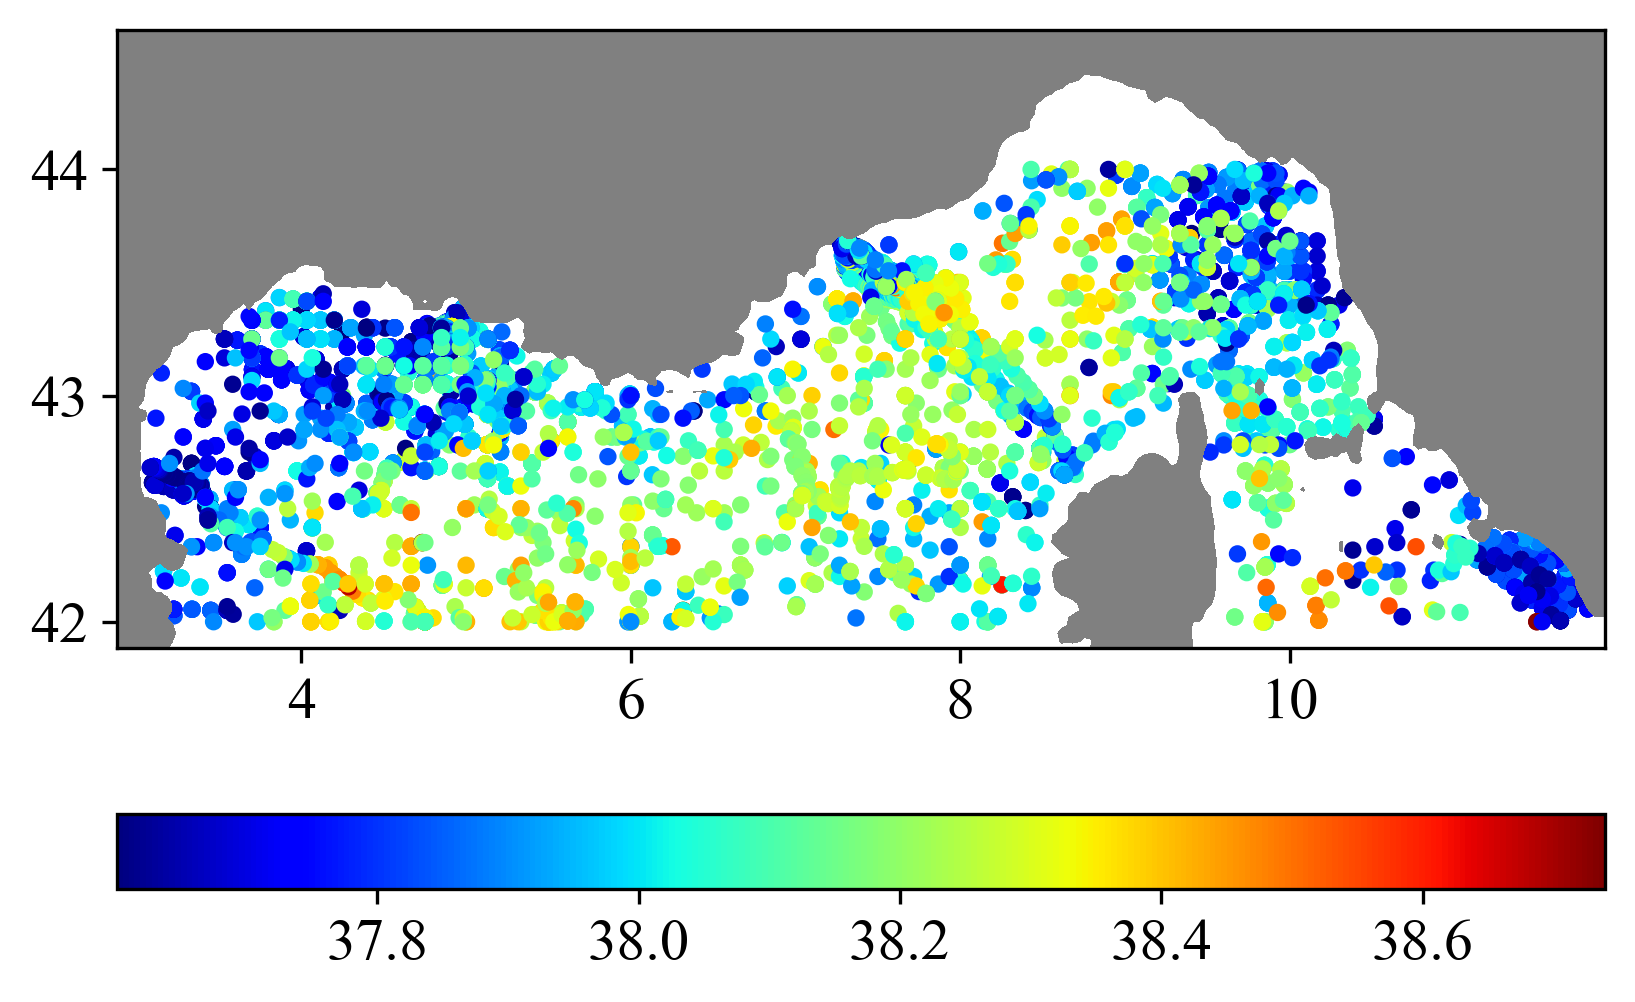

In [14]:
sel = DIVAnd.select(TS,2,obstime) .& (obsdepth .< 5);
scatter(obslon[sel],obslat[sel],10,obsvalue[sel], cmap="jet"); 
colorbar(orientation = "horizontal");
contourf(bx,by,b', levels = [-1e5,0],colors = [[.5,.5,.5]])
aspectratio = 1/cos(mean(latr) * pi/180)
gca().set_aspect(aspectratio)

The vertical average is controled by a parameter `searchz` defined using the vertical resolution. `searchz` is a list of tuples where every tuple composed by an upper and lower bound.

In [15]:
searchz = DIVAnd.background_profile_searchz(depthr)


51-element Array{Tuple{Float64,Float64},1}:
 (0.0, 2.5)
 (2.5, 7.5)
 (7.5, 12.5)
 (12.5, 17.5)
 (17.5, 22.5)
 (22.5, 27.5)
 (27.5, 35.0)
 (35.0, 45.0)
 (45.0, 58.0)
 (58.0, 70.5)
 (70.5, 80.0)
 (80.0, 92.5)
 (92.5, 106.0)
 ⋮
 (1125.0, 1175.0)
 (1175.0, 1225.0)
 (1225.0, 1275.0)
 (1275.0, 1325.0)
 (1325.0, 1375.0)
 (1375.0, 1425.0)
 (1425.0, 1475.0)
 (1475.0, 1550.0)
 (1550.0, 1675.0)
 (1675.0, 1800.0)
 (1800.0, 1925.0)
 (1925.0, 2000.0)

The surface value is this the average between 0 and 2.5 meters. Let's check:

In [16]:
sel = DIVAnd.select(TS,1,obstime) .& (0 .<= obsdepth .<= 2.5);
@show mean(obsvalue[sel])
@show S[1,1];

mean(obsvalue[sel]) = 38.07323237632587
S[1, 1] = 38.07323f0


Additional smoothing by increasing the value of the optional argument factor

In [17]:
searchz = DIVAnd.background_profile_searchz(depthr, factor=3)


51-element Array{Tuple{Float64,Float64},1}:
 (-2.5, 5.0)
 (-2.5, 12.5)
 (2.5, 17.5)
 (7.5, 22.5)
 (12.5, 27.5)
 (17.5, 32.5)
 (20.0, 42.5)
 (25.0, 55.0)
 (32.0, 71.0)
 (45.5, 83.0)
 (61.0, 89.5)
 (67.5, 105.0)
 (79.0, 119.5)
 ⋮
 (1075.0, 1225.0)
 (1125.0, 1275.0)
 (1175.0, 1325.0)
 (1225.0, 1375.0)
 (1275.0, 1425.0)
 (1325.0, 1475.0)
 (1375.0, 1525.0)
 (1400.0, 1625.0)
 (1425.0, 1800.0)
 (1550.0, 1925.0)
 (1675.0, 2050.0)
 (1850.0, 2075.0)

In [18]:
background_filename2 = "average_background_profile2_$(varname).nc"

if isfile(background_filename2)
    rm(background_filename2)
end

DIVAnd.average_background_profile(
    background_filename2, (lonr,latr,depthr,TS), (obslon, obslat, obsdepth, obstime), obsvalue,
    epsilon2,
    varname, searchz = searchz)

┌ Info: Time step 1 / 4
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/average_background_profile.jl:89
┌ Info: Time step 2 / 4
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/average_background_profile.jl:89
┌ Info: Time step 3 / 4
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/average_background_profile.jl:89
┌ Info: Time step 4 / 4
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/average_background_profile.jl:89


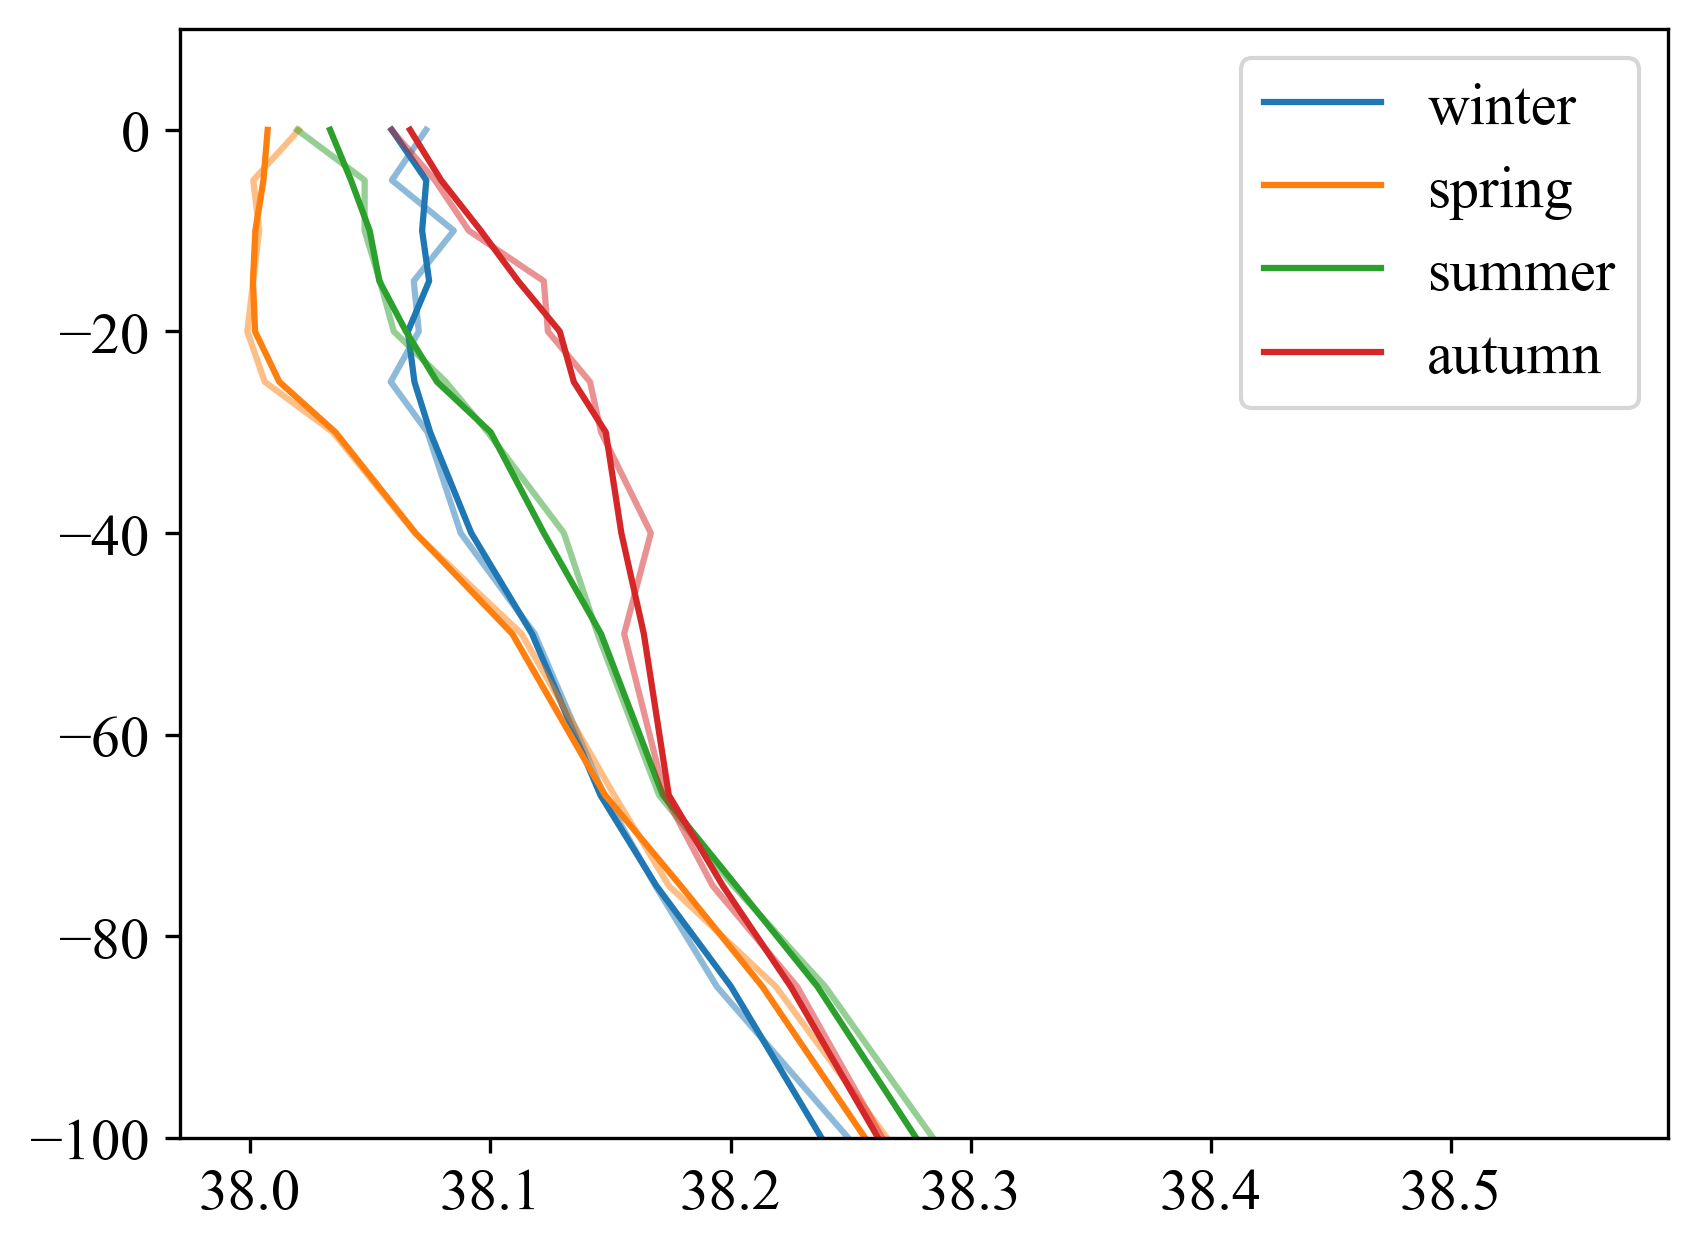

In [19]:
ds = Dataset(background_filename2)
S2 = ds["Salinity"][1,1,:,:]
close(ds)
seasons = ["winter","spring","summer","autumn"]
for n = 1:length(seasons)
  p = plot(S2[:,n],-depthr,label=seasons[n])
  plot(S[:,n],-depthr, color=p[1].get_color(),alpha = 0.5)
end
legend();
ylim(-100,10);

## Exercise
* Comment-out the quality check in the beginning and redo the other plots
* Compare the results